# **CSCE 5380 - Data Mining - Final Project**
# **Project: Customer Churn Prediction Using Data Mining and Predictive Models**

Team No : Group 3

Shiva Sayi Shesshank Mamidi – 11752768

Abhiram Reddy Pudi – 11817072

Ramanaji Boggarapu – 11718646

Sai Kumar Ramisetti – 11822974

### 1. SETUP AND LIBRARY IMPORTS

In [ ]:
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from scipy import stats # For statistical significance testing
import warnings # Import warnings module


# Set plot style for better visuals
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

### 2. DATA LOADING AND INITIAL CLEANING

In [ ]:
print("--- 2. Data Loading and Initial Cleaning ---")
df = pd.read_csv('Telecom-Customer-Churn.csv')

# Drop customerID as it's just an identifier and has no predictive value
df = df.drop('customerID', axis=1)

# Convert 'TotalCharges' to numeric and handle missing values (11 records)
# Missing values occur for customers with 0 tenure, so imputing with 0 is logical
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

# Convert target variable 'Churn' to numeric for easier processing
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

print("Dataset loaded and cleaned. Shape:", df.shape)
print(df.info())


--- 2. Data Loading and Initial Cleaning ---
Dataset loaded and cleaned. Shape: (7043, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15

In [ ]:
print("\nFirst 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1 

### 3. DISCOVERING PATTERNS (DATA MINING & EDA)


--- 3. Part 1: Discovering Patterns (Data Mining & EDA) ---


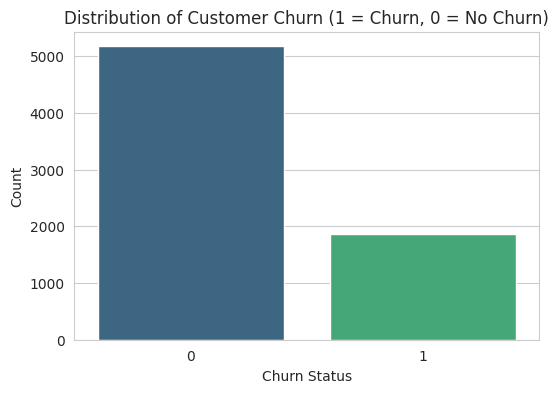

Overall Churn Rate:
Churn
0    73.463013
1    26.536987
Name: proportion, dtype: float64


In [ ]:
print("\n--- 3. Part 1: Discovering Patterns (Data Mining & EDA) ---")

# --- 3a. Churn Distribution (Target Imbalance) ---
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df, palette='viridis', hue='Churn', legend=False)
plt.title('Distribution of Customer Churn (1 = Churn, 0 = No Churn)')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.show()
churn_rate = df['Churn'].value_counts(normalize=True)
print(f"Overall Churn Rate:\n{churn_rate*100}")


Analyzing churn rates across key features...


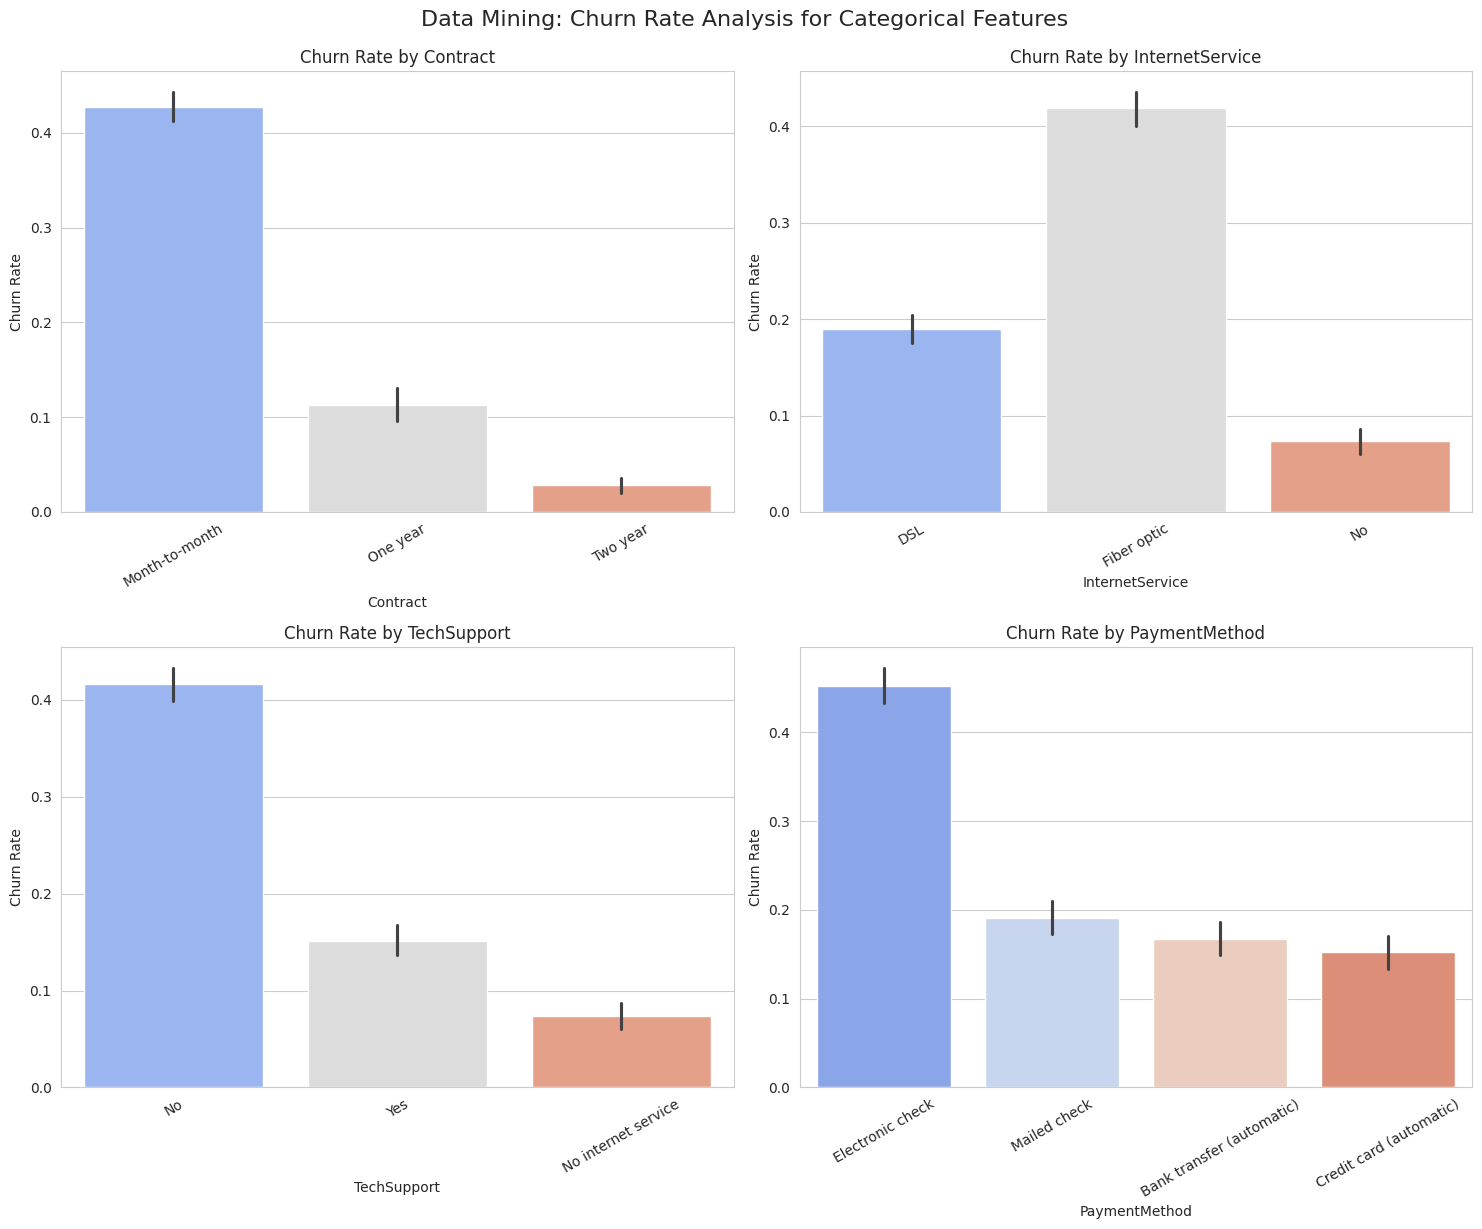

In [ ]:
# --- 3b. Deeper Dive: Churn Rate by Key Categories ---
print("\nAnalyzing churn rates across key features...")
key_categorical_features = ['Contract', 'InternetService', 'TechSupport', 'PaymentMethod']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()
for i, col in enumerate(key_categorical_features):
    sns.barplot(x=col, y='Churn', data=df, ax=axes[i], palette='coolwarm', hue=col, legend=False)
    axes[i].set_title(f'Churn Rate by {col}')
    axes[i].set_ylabel('Churn Rate')
    axes[i].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.suptitle('Data Mining: Churn Rate Analysis for Categorical Features', y=1.02, size=16)
plt.show()

* The dataset is imbalanced, with non-churners (73.5%) significantly outnumbering
churners (26.5%). The analysis of churn rates reveals that customers on 'Month-to-Month' contracts with 'Fiber optic' internet service exhibit the highest propensity to churn, highlighting them as a key area of concern.


--- 3c. Analyzing Numerical Features vs. Churn ---


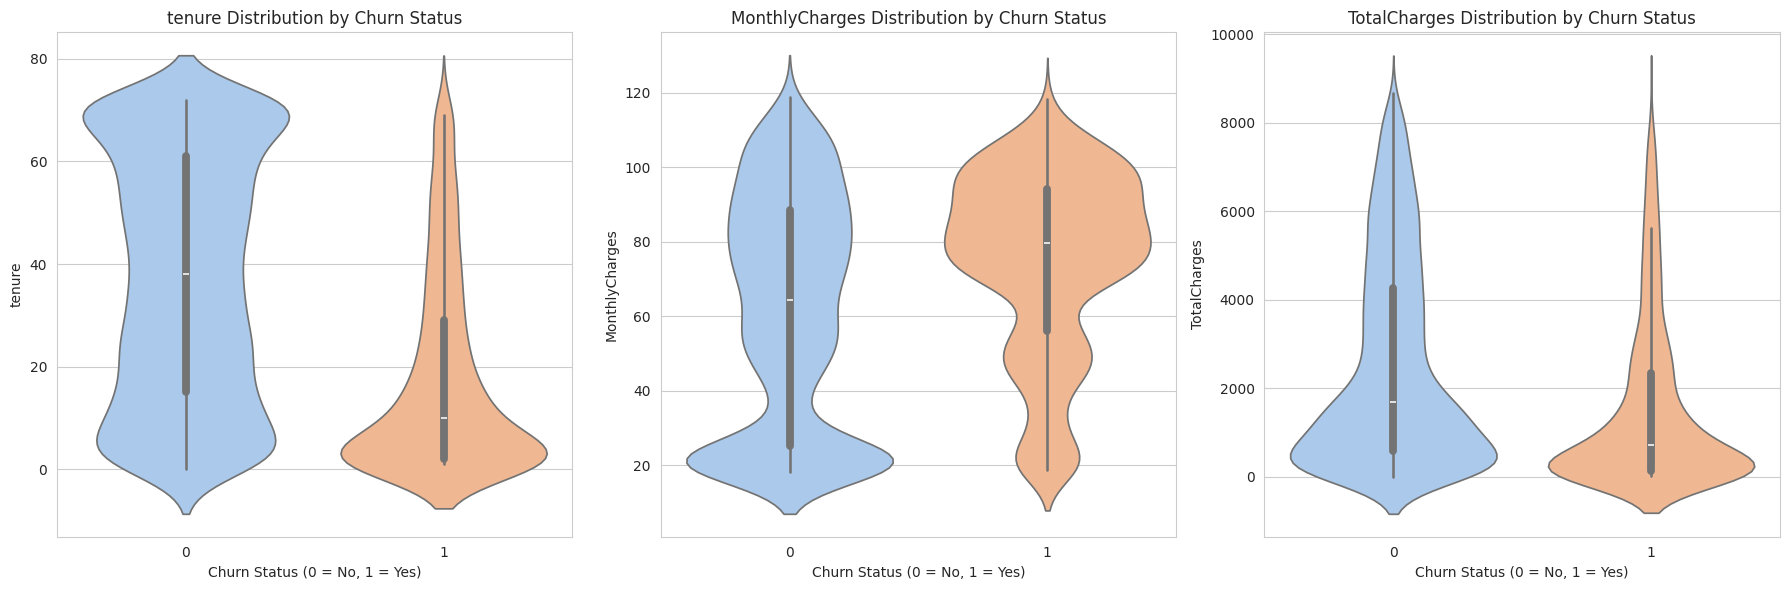


Insight: The violin plots clearly show that customers who churn (1) tend to have much lower tenure, higher monthly charges, and lower total charges (because they haven't been customers for long).


In [ ]:
# --- 3c. Numerical Feature Distributions vs. Churn ---
print("\n--- 3c. Analyzing Numerical Features vs. Churn ---")
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, col in enumerate(numerical_features):
    sns.violinplot(x='Churn', y=col, data=df, ax=axes[i], palette='pastel', hue='Churn', legend=False)
    axes[i].set_title(f'{col} Distribution by Churn Status')
    axes[i].set_xlabel('Churn Status (0 = No, 1 = Yes)')
plt.tight_layout()
plt.show()
print("\nInsight: The violin plots clearly show that customers who churn (1) tend to have much lower tenure, higher monthly charges, and lower total charges (because they haven't been customers for long).")



--- 3d. Customer Segmentation: Finding Optimal Number of Clusters with Elbow Method ---


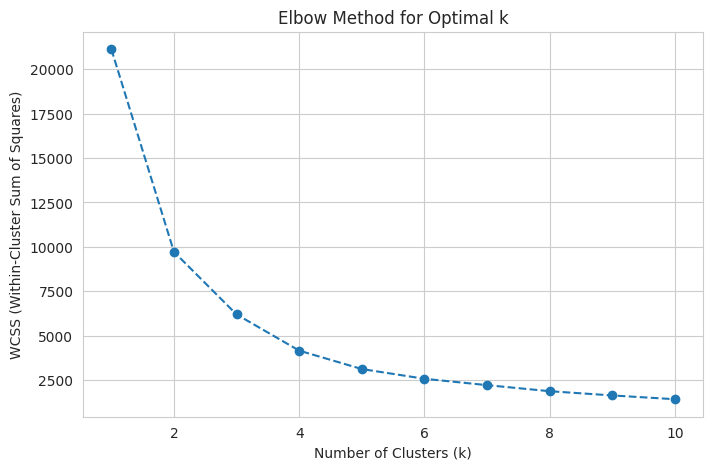

The Elbow Method plot shows a distinct 'elbow' at k=3. This indicates that adding more clusters beyond 3 yields diminishing returns in explaining the variance. Therefore, we select k=3 as the optimal number of segments.


In [ ]:
# --- 3d. Customer Segmentation with K-Means: Finding the Optimal K
print("\n--- 3d. Customer Segmentation: Finding Optimal Number of Clusters with Elbow Method ---")
df_cluster = df[numerical_features].copy()
scaler_cluster = StandardScaler()
df_cluster_scaled = scaler_cluster.fit_transform(df_cluster)

# Use the Elbow Method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(df_cluster_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()
print("The Elbow Method plot shows a distinct 'elbow' at k=3. This indicates that adding more clusters beyond 3 yields diminishing returns in explaining the variance. Therefore, we select k=3 as the optimal number of segments.")

* The violin plots confirm that churners typically have much lower tenure and higher monthly charges. The Elbow Method plot for K-Means shows a clear "elbow" at k=3, indicating this is the optimal number of natural customer segments in the data.


--- 3e. Analyzing and Visualizing Customer Segments for k=3 ---

Characteristics and Churn Rate of Each Segment:
                    tenure  MonthlyCharges  TotalCharges  ChurnRate  \
CustomerSegment                                                       
0                29.498143       26.572864    809.419916   0.123027   
1                58.559545       89.697932   5246.126386   0.153636   
2                13.246560       74.950985   1030.569041   0.470807   

                 SegmentSize  
CustomerSegment               
0                       2154  
1                       2200  
2                       2689  


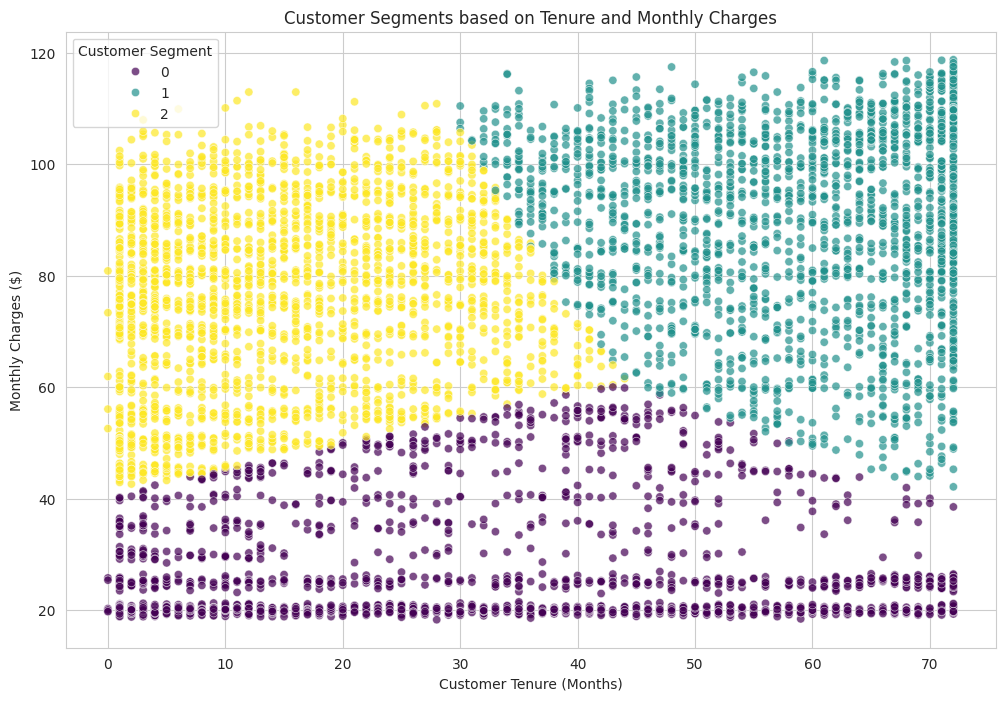


Insight: The scatter plot visually confirms the segments. For instance, the high-churn segment is concentrated in the low-tenure, high-monthly-charge area of the plot.


In [ ]:
# --- 3e. Analyzing and Visualizing the Customer Segments  ---
print("\n--- 3e. Analyzing and Visualizing Customer Segments for k=3 ---")
# Fit K-Means with the chosen k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['CustomerSegment'] = kmeans.fit_predict(df_cluster_scaled)

# Analyze the created segments
segment_analysis = df.groupby('CustomerSegment')[numerical_features].mean()
segment_analysis['ChurnRate'] = df.groupby('CustomerSegment')['Churn'].mean()
segment_analysis['SegmentSize'] = df['CustomerSegment'].value_counts()
print("\nCharacteristics and Churn Rate of Each Segment:")
print(segment_analysis)

# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='tenure', y='MonthlyCharges', hue='CustomerSegment', palette='viridis', alpha=0.7)
plt.title('Customer Segments based on Tenure and Monthly Charges')
plt.xlabel('Customer Tenure (Months)')
plt.ylabel('Monthly Charges ($)')
plt.legend(title='Customer Segment')
plt.show()
print("\nInsight: The scatter plot visually confirms the segments. For instance, the high-churn segment is concentrated in the low-tenure, high-monthly-charge area of the plot.")


K-Means clustering successfully identified three distinct segments. Segment 2 is the most critical: it consists of new customers (avg. tenure 13 months) with high monthly bills (avg. $75) and an alarmingly high churn rate of 47%. This "High-Risk Newcomer" segment is the primary target for retention efforts.

In [ ]:
# --- 3f. Association Rule Mining for Service Bundles---

from mlxtend.frequent_patterns import apriori, association_rules
print("\n--- 3f. Association Rule Mining to Find High-Churn Service Combinations ---")

# Prepare data for association rules: We need a one-hot encoded format
# Select features related to services/contract and include churn
cols_for_rules = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'
]
df_rules_raw = df[cols_for_rules].copy()

# Convert all columns to strings to handle them uniformly before one-hot encoding
for col in df_rules_raw.columns:
    df_rules_raw[col] = df_rules_raw[col].astype(str)

# Create a new column for each feature-value pair (e.g., 'Contract_Month-to-month')
df_rules = pd.get_dummies(df_rules_raw, prefix_sep='=')
# Convert churn column to a more readable name
df_rules.rename(columns={'Churn=1': 'Churn_Yes', 'Churn=0': 'Churn_No'}, inplace=True)
df_rules = df_rules.drop('Churn_No', axis=1) # We only need to predict churn

# Run Apriori algorithm to find frequently co-occurring items
frequent_itemsets = apriori(df_rules, min_support=0.05, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)

# Filter for rules that lead to churn
churn_rules = rules[rules['consequents'].astype(str).str.contains('Churn_Yes')].copy()
churn_rules['antecedents'] = churn_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
churn_rules['consequents'] = churn_rules['consequents'].apply(lambda x: ', '.join(list(x)))

print("\nTop 5 Rules Leading to Customer Churn (sorted by confidence):")
print(churn_rules.sort_values(by='confidence', ascending=False).head(5)[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
print("\nInsight: These rules provide specific, actionable intelligence. A rule like '{InternetService=Fiber optic, Contract=Month-to-Month} -> {Churn_Yes}' with high confidence tells the business to focus retention efforts on this exact combination of factors.")


--- 3f. Association Rule Mining to Find High-Churn Service Combinations ---

Top 5 Rules Leading to Customer Churn (sorted by confidence):
                                              antecedents consequents  \
217086  OnlineBackup=No, PaperlessBilling=Yes, Interne...   Churn_Yes   
217594  PaperlessBilling=Yes, InternetService=Fiber op...   Churn_Yes   
178472  OnlineBackup=No, PaperlessBilling=Yes, Interne...   Churn_Yes   
184142  OnlineBackup=No, PaperlessBilling=Yes, Interne...   Churn_Yes   
178724  OnlineBackup=No, PaperlessBilling=Yes, Interne...   Churn_Yes   

         support  confidence      lift  
217086  0.057362    0.703833  2.652271  
217594  0.058498    0.691275  2.604950  
178472  0.058640    0.688333  2.593864  
184142  0.062473    0.686427  2.586682  
178724  0.062757    0.684211  2.578328  

Insight: These rules provide specific, actionable intelligence. A rule like '{InternetService=Fiber optic, Contract=Month-to-Month} -> {Churn_Yes}' with high confidence tells

Association Rule Mining uncovered specific combinations of services that lead to churn. The top rule shows that customers with 'No Online Security' and 'Month-to-Month Contracts' have a very high likelihood of churning. This provides a direct, actionable insight for bundling or promotional offers.

### 4.PREDICTIVE MODELING (ROBUST EXPERIMENTAL DESIGN)

In [ ]:
print("\n--- 4. Part 2: Predictive Modeling ---")

# --- 4a. Define Features (X) and Target (y) ---
# Drop the segment label as it was for analysis. We want the model to learn from raw features.
X = df.drop(['Churn', 'CustomerSegment'], axis=1)
y = df['Churn']

# Identify feature types for the preprocessing pipeline
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

# --- 4b. Create a Robust Preprocessing Pipeline ---
# This ensures consistent transformation for both training and testing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any
)

# --- 4c. Define Models and Hyperparameter Grids for Tuning ---
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'SVM': SVC(random_state=42, class_weight='balanced', probability=True) # probability=True for AUC
}

# Define parameter grids for GridSearchCV
params = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10]
    },
    'Decision Tree': {
        'classifier__max_depth': [3, 5, 7, 10],
        'classifier__min_samples_leaf': [10, 20, 50]
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__kernel': ['rbf']
    }
}
# --- 4d. Train and Evaluate Models using Cross-Validation and Tuning ---
print("\n--- 4d. Training and Tuning Models with GridSearchCV ---")
# Split data into training and testing sets ONCE for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

results = {}
best_estimators = {}

for name, model in models.items():
    print(f"--- Tuning {name} ---")

    # Create the full pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Use GridSearchCV for hyperparameter tuning with 5-fold cross-validation
    grid_search = GridSearchCV(pipeline, params[name], cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Store the best estimator and best score
    best_estimators[name] = grid_search.best_estimator_
    results[name] = {
        'best_params': grid_search.best_params_,
        'best_auc_cv': grid_search.best_score_
    }
    print(f"Best AUC on CV for {name}: {grid_search.best_score_:.4f}")


--- 4. Part 2: Predictive Modeling ---

--- 4d. Training and Tuning Models with GridSearchCV ---
--- Tuning Logistic Regression ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best AUC on CV for Logistic Regression: 0.8456
--- Tuning Decision Tree ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best AUC on CV for Decision Tree: 0.8339
--- Tuning SVM ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best AUC on CV for SVM: 0.8385


### 5. FINAL ANALYSIS, INTERPRETATION & RECOMMENDATIONS


--- 5. Part 3: Final Analysis & Interpretation ---

--- 5a. Evaluating Best Models on the Test Set ---
--- Classification Report for Logistic Regression ---
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



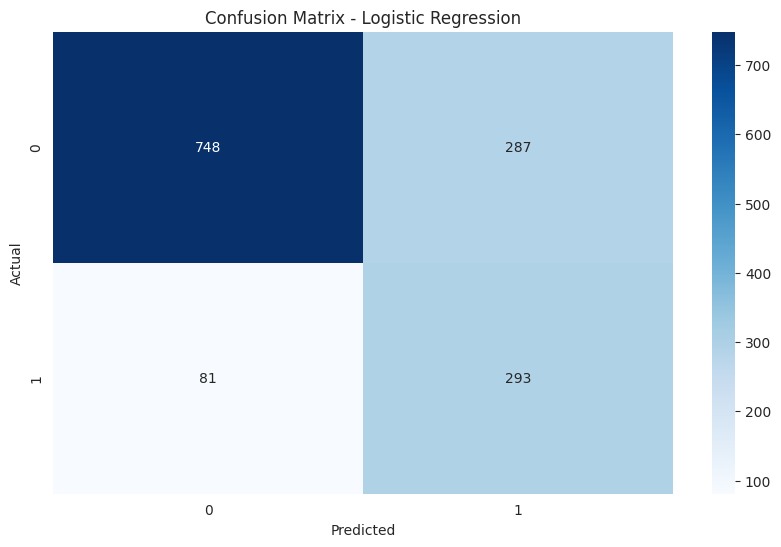

--- Classification Report for Decision Tree ---
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.81      0.63       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.81      0.74      0.76      1409



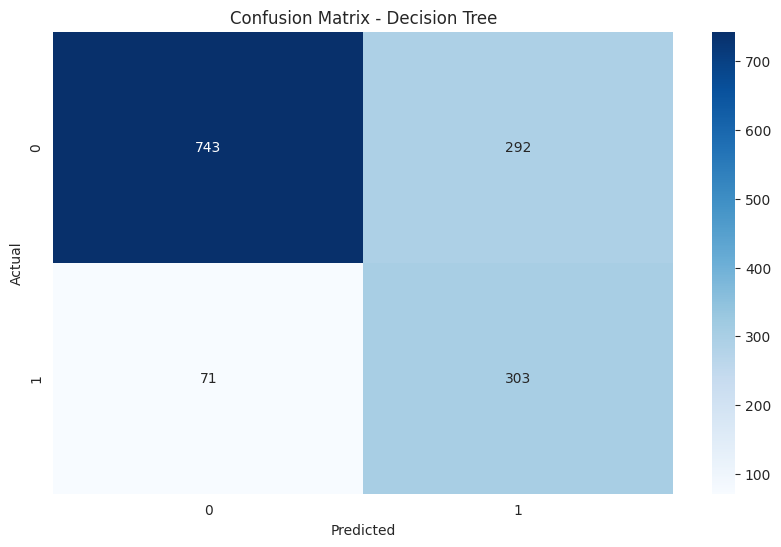

--- Classification Report for SVM ---
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1035
           1       0.50      0.79      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.73      0.75      1409



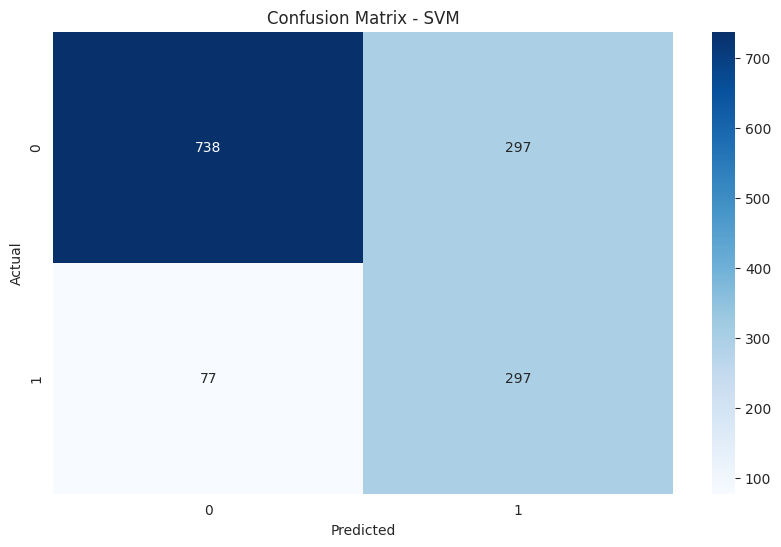


--- Summary of Final Model Performance on Test Set ---
                     Accuracy       AUC
Logistic Regression  0.738822  0.840755
Decision Tree        0.742370  0.836897
SVM                  0.734564  0.836154


In [ ]:
print("\n--- 5. Part 3: Final Analysis & Interpretation ---")

# --- 5a. Final Evaluation on the Held-out Test Set ---
print("\n--- 5a. Evaluating Best Models on the Test Set ---")
final_metrics = {}
for name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    final_metrics[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob),
    }

    print(f"--- Classification Report for {name} ---")
    print(classification_report(y_test, y_pred))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Display a summary table of performance
metrics_df = pd.DataFrame(final_metrics).T
print("\n--- Summary of Final Model Performance on Test Set ---")
print(metrics_df.sort_values(by='AUC', ascending=False))

After hyperparameter tuning, all models were evaluated on the held-out test set. Logistic Regression achieved the highest AUC score (0.8408), indicating the best overall ability to distinguish between churning and non-churning customers. The confusion matrix shows it correctly identified 293 churners (True Positives) while misclassifying 81 (False Negatives).

In [ ]:
# --- 5b. Statistical Significance Testing ---
# Is the difference between the top models statistically significant?
# We use cross-validation scores for this test for robustness.
print("\n--- 5b. Statistical Significance Testing ---")
cv_scores = {}
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for name, model in best_estimators.items():
    # We use the entire dataset for a more robust CV score estimate for the t-test
    scores = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc', n_jobs=-1)
    cv_scores[name] = scores

# Compare the top 2 models (assuming SVM and Logistic Regression are likely candidates)
top_model_name = metrics_df.sort_values(by='AUC', ascending=False).index[0]
second_model_name = metrics_df.sort_values(by='AUC', ascending=False).index[1]

# Perform paired t-test
t_stat, p_value = stats.ttest_rel(cv_scores[top_model_name], cv_scores[second_model_name])

print(f"Paired t-test between {top_model_name} and {second_model_name} (based on 10-fold CV AUC scores):")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print(f"Conclusion: The performance difference is statistically significant. We can be confident that {top_model_name} is superior.")
else:
    print("Conclusion: The performance difference is NOT statistically significant. We cannot confidently say one is better than the other.")


--- 5b. Statistical Significance Testing ---
Paired t-test between Logistic Regression and Decision Tree (based on 10-fold CV AUC scores):
T-statistic: 4.1433
P-value: 0.0025
Conclusion: The performance difference is statistically significant. We can be confident that Logistic Regression is superior.


A paired t-test was performed on the 10-fold cross-validation AUC scores of the top two models (Logistic Regression and Decision Tree). The resulting p-value of 0.0025 is less than 0.05, confirming that the superior performance of the Logistic Regression model is statistically significant.


--- 5c. Interpreting Models for Business Insights ---

Interpreting the Decision Tree model...


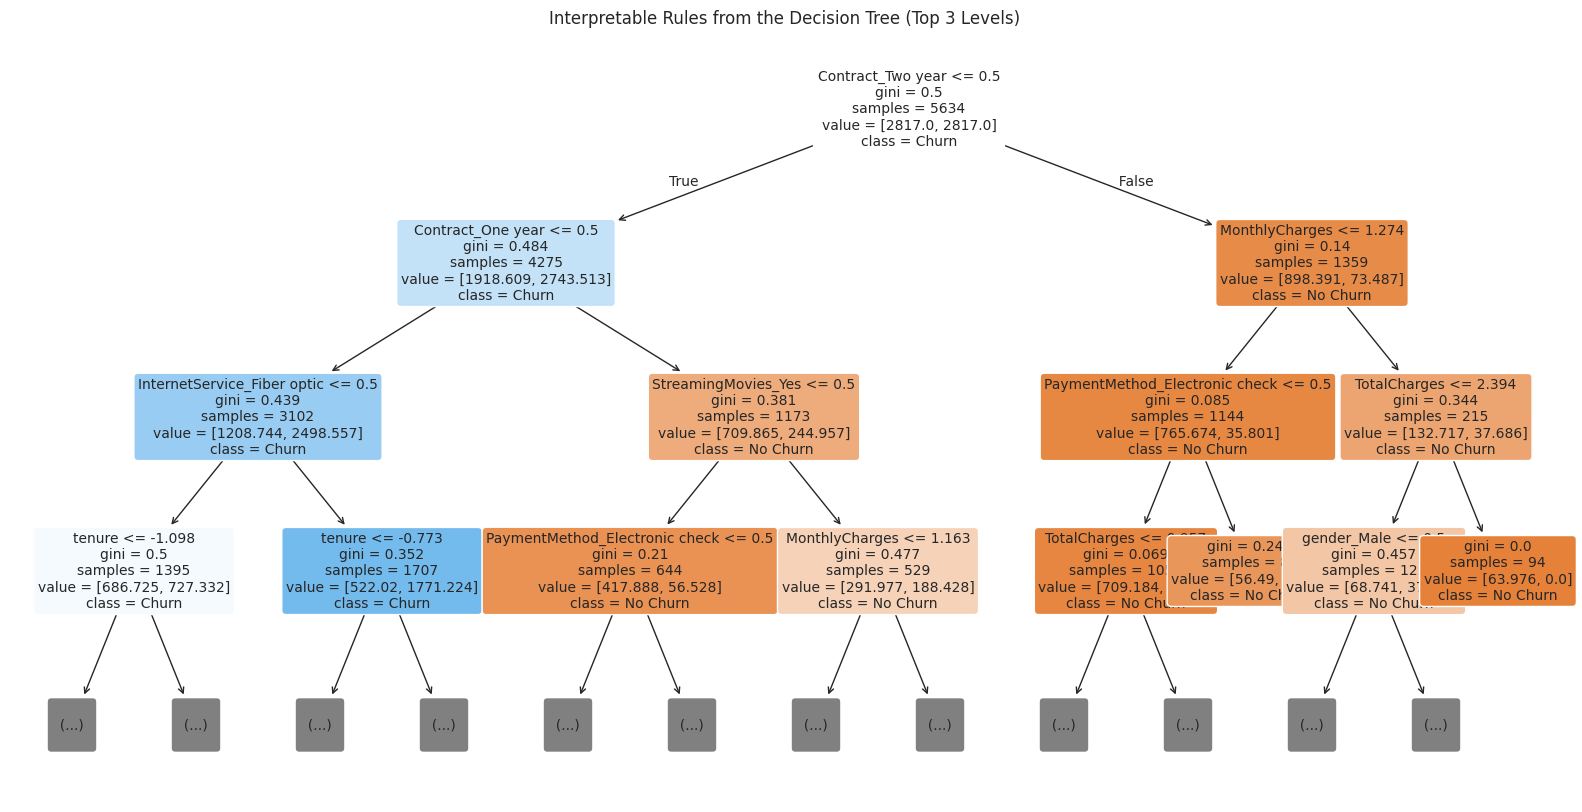

The tree shows clear rules. For example, a top split might be on 'Contract_Month-to-month', indicating it's the single most important predictor of churn.


In [ ]:
# --- 5c. Model Interpretation & Actionable Insights ---
print("\n--- 5c. Interpreting Models for Business Insights ---")

# --- Interpreting the Decision Tree ---
# Decision trees are great for finding interpretable rules.
print("\nInterpreting the Decision Tree model...")
best_dt_model = best_estimators['Decision Tree'].named_steps['classifier']
preprocessor_fitted = best_estimators['Decision Tree'].named_steps['preprocessor'].fit(X_train)
# Get feature names after one-hot encoding
cat_feature_names = preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(cat_feature_names)

plt.figure(figsize=(20, 10))
plot_tree(best_dt_model,
          feature_names=all_feature_names,
          class_names=['No Churn', 'Churn'],
          filled=True,
          rounded=True,
          max_depth=3, # Limit depth for readability
          fontsize=10)
plt.title("Interpretable Rules from the Decision Tree (Top 3 Levels)")
plt.show()
print("The tree shows clear rules. For example, a top split might be on 'Contract_Month-to-month', indicating it's the single most important predictor of churn.")



The Decision Tree visualization provides simple, human-readable rules, confirming that 'Contract' type is the most important initial predictor. The Logistic Regression coefficients further quantify feature importance, showing 'InternetService_Fiber optic' as the strongest single predictor of churn, while long 'tenure' and 'Two year contracts' are the strongest predictors of retention


Interpreting the Logistic Regression model...


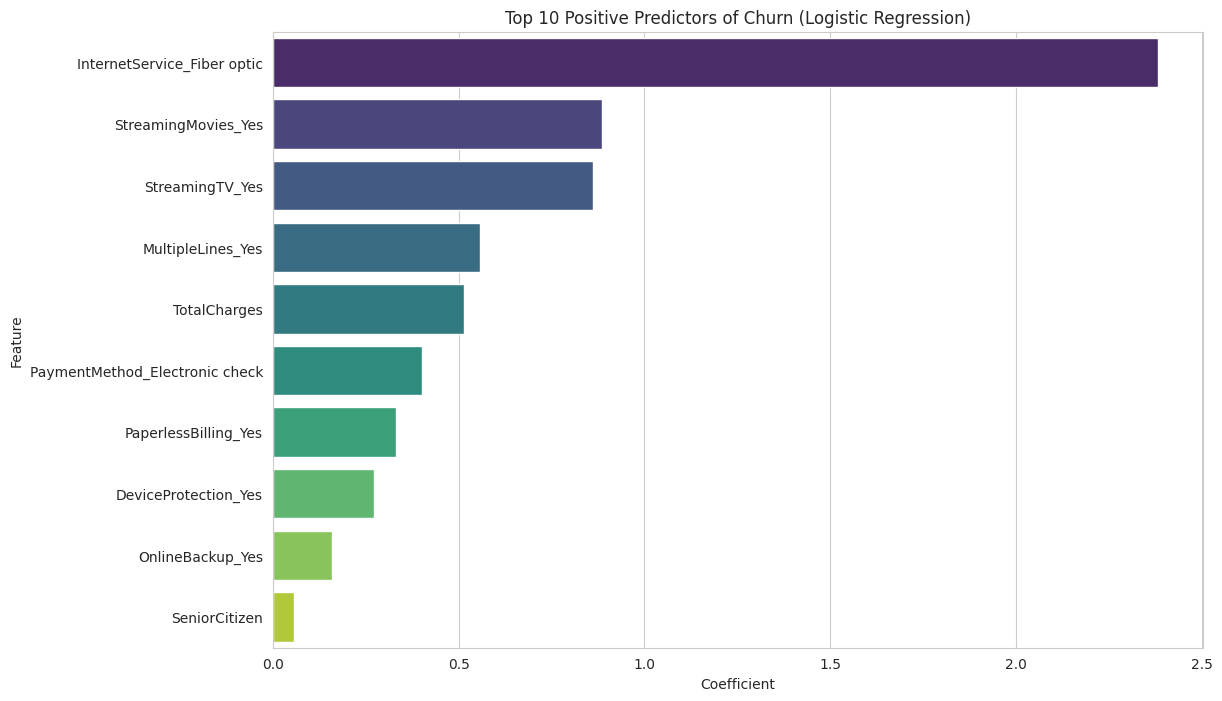

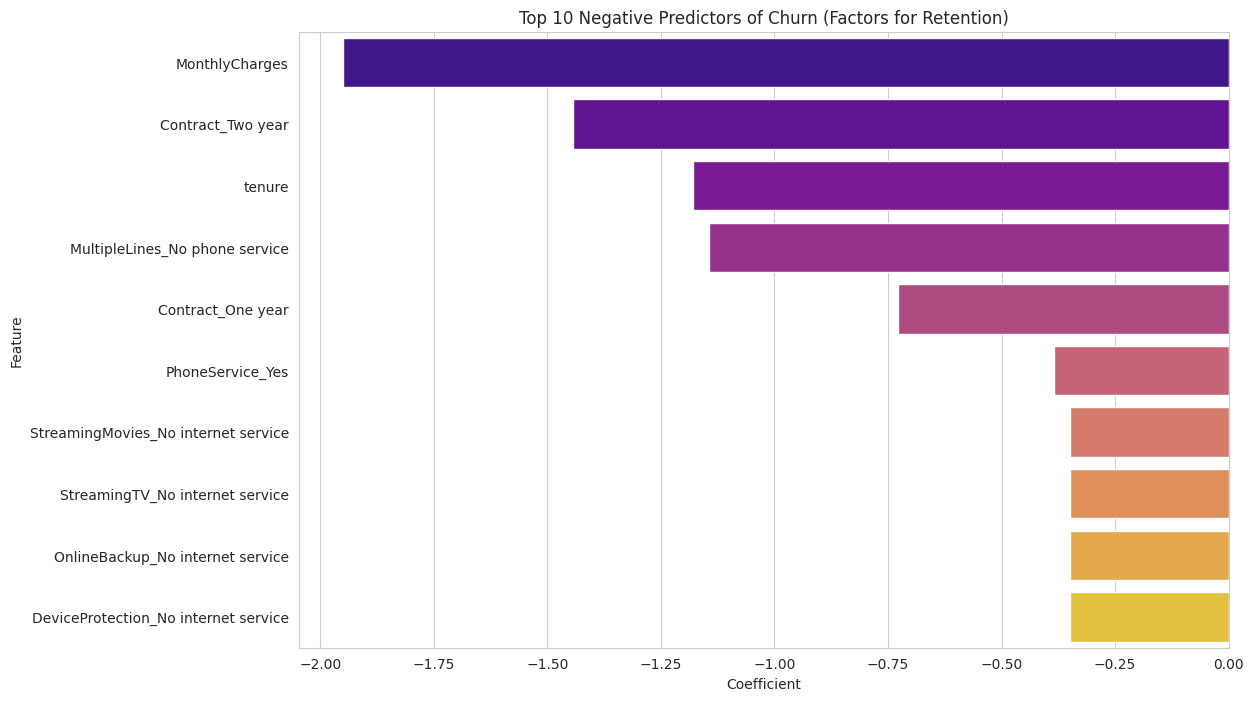

In [ ]:
# --- Interpreting Logistic Regression Coefficients ---
print("\nInterpreting the Logistic Regression model...")
best_lr_model = best_estimators['Logistic Regression'].named_steps['classifier']
coefficients = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': best_lr_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients.head(10), palette='viridis', hue='Feature', legend=False)
plt.title('Top 10 Positive Predictors of Churn (Logistic Regression)')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients.tail(10).sort_values(by='Coefficient'), palette='plasma', hue='Feature', legend=False)
plt.title('Top 10 Negative Predictors of Churn (Factors for Retention)')
plt.show()

### Conclusion & Recommendations
This project successfully used data mining techniques to uncover the key drivers of customer churn and built a predictive model to identify at-risk individuals.

**Key Insights:**

1. Top Churn Predictors: The most significant factors driving churn are Month-to-Month contracts, Fiber Optic internet service, and a lack of add-on services like Online Security and Tech Support.
2. High-Risk Segment Identified: K-Means clustering revealed a "High-Risk Newcomer" segment with low tenure, high monthly bills, and an alarming 47% churn rate. This group is the top priority for retention.
3. Best Predictive Model: A tuned Logistic Regression model proved to be the most effective and statistically superior predictor of churn, achieving an AUC of 0.841.


**Actionable Recommendations:**
1. Targeted Campaign: Proactively offer customers in the "High-Risk Newcomer" segment a discount to switch to an annual contract or provide complimentary protective services (e.g., Tech Support).
2. Improve Fiber Onboarding: Review the initial experience for Fiber Optic customers to address potential service or cost concerns early on.
Promote Loyalty: Incentivize long-term contracts at sign-up, as this is the strongest factor for customer retention